In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:20000,:]

In [6]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['Why is she hiding?', 'Warum versteckt sie sich?'],
       ['Why is snow white?', 'Warum ist Schnee weiß?'],
       ["Why isn't it good?", 'Warum ist es nicht gut?']], dtype='<U380')

In [7]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['Why is she hiding', 'Warum versteckt sie sich'],
       ['Why is snow white', 'Warum ist Schnee weiß'],
       ['Why isnt it good', 'Warum ist es nicht gut']], dtype='<U380')

In [8]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['why is she hiding', 'warum versteckt sie sich'],
       ['why is snow white', 'warum ist schnee weiß'],
       ['why isnt it good', 'warum ist es nicht gut']], dtype='<U380')

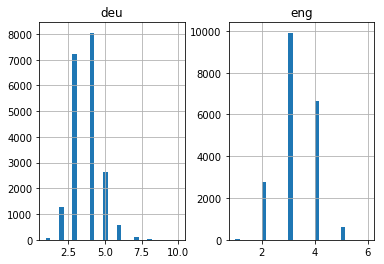

In [9]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [11]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3822


In [12]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 5938


In [13]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(lr=0.001,rho=0.8)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'model_file'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Train on 12800 samples, validate on 3200 samples
Epoch 1/30
12800/12800 [==============================] - 113s 9ms/step - loss: 3.7857 - val_loss: 2.7134

Epoch 00001: val_loss improved from inf to 2.71338, saving model to model_file
Epoch 2/30
12800/12800 [==============================] - 109s 8ms/step - loss: 2.5995 - val_loss: 2.5364

Epoch 00002: val_loss improved from 2.71338 to 2.53642, saving model to model_file
Epoch 3/30
12800/12800 [==============================] - 109s 9ms/step - loss: 2.4402 - val_loss: 2.4930

Epoch 00003: val_loss improved from 2.53642 to 2.49302, saving model to model_file
Epoch 4/30
12800/12800 [==============================] - 106s 8ms/step - loss: 2.3658 - val_loss: 2.3894

Epoch 00004: val_loss improved from 2.49302 to 2.38938, saving model to model_file
Epoch 5/30
12800/12800 [==============================] - 113s 9ms/step - loss: 2.2926 - val_loss: 2.3501

Epoch 00005: val_loss improved from 2.38938 to 2.35008, saving model to model_file
Epoch

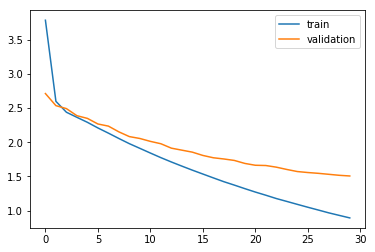

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('model_file')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [22]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [23]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0],'German':test[:,1] ,'predicted' : preds_text})

In [25]:
pred_df.sample(15)

,German,actual,predicted
3651,tom wurde ruhig,tom became calm,tom stayed upset
2873,möchten sie hier essen,is it for here,do you want here
375,ich mache mit,ill join you,i go you
1662,tom eilte davon,tom hurried away,tom believes off
264,glaubt ihr das,do you think so,do it do
1128,versuchen sie es noch einmal,try it again,try it again
2105,tom war stark,tom was strong,tom was hungry
1369,tom ist klug,tom is clever,tom is
3807,ich kann sprechen,im able to speak,i can go
2343,das habe ich nicht so gemeint,i didnt mean it,i dont be
